In [1]:
# Data Management/Investigation
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

In [2]:
# Import Test Data on Housing Prices in DC
dat_test = pd.read_csv("test_data.csv")
dat_test.shape

(14531, 39)

In [3]:
# Import Train Data on Housing Prices in DC
dat_train = pd.read_csv("train_data.csv")
dat_train.shape

(43590, 39)

In [4]:
# Available features
list(dat_test)

['OBJECTID',
 'SSL',
 'BATHRM',
 'HF_BATHRM',
 'HEAT',
 'HEAT_D',
 'AC',
 'NUM_UNITS',
 'ROOMS',
 'BEDRM',
 'AYB',
 'YR_RMDL',
 'EYB',
 'STORIES',
 'SALEDATE',
 'QUALIFIED',
 'SALE_NUM',
 'GBA',
 'BLDG_NUM',
 'STYLE',
 'STYLE_D',
 'STRUCT',
 'STRUCT_D',
 'GRADE',
 'GRADE_D',
 'CNDTN',
 'CNDTN_D',
 'EXTWALL',
 'EXTWALL_D',
 'ROOF',
 'ROOF_D',
 'INTWALL',
 'INTWALL_D',
 'KITCHENS',
 'FIREPLACES',
 'USECODE',
 'LANDAREA',
 'GIS_LAST_MOD_DTTM',
 'LN_PRICE']

<AxesSubplot:>

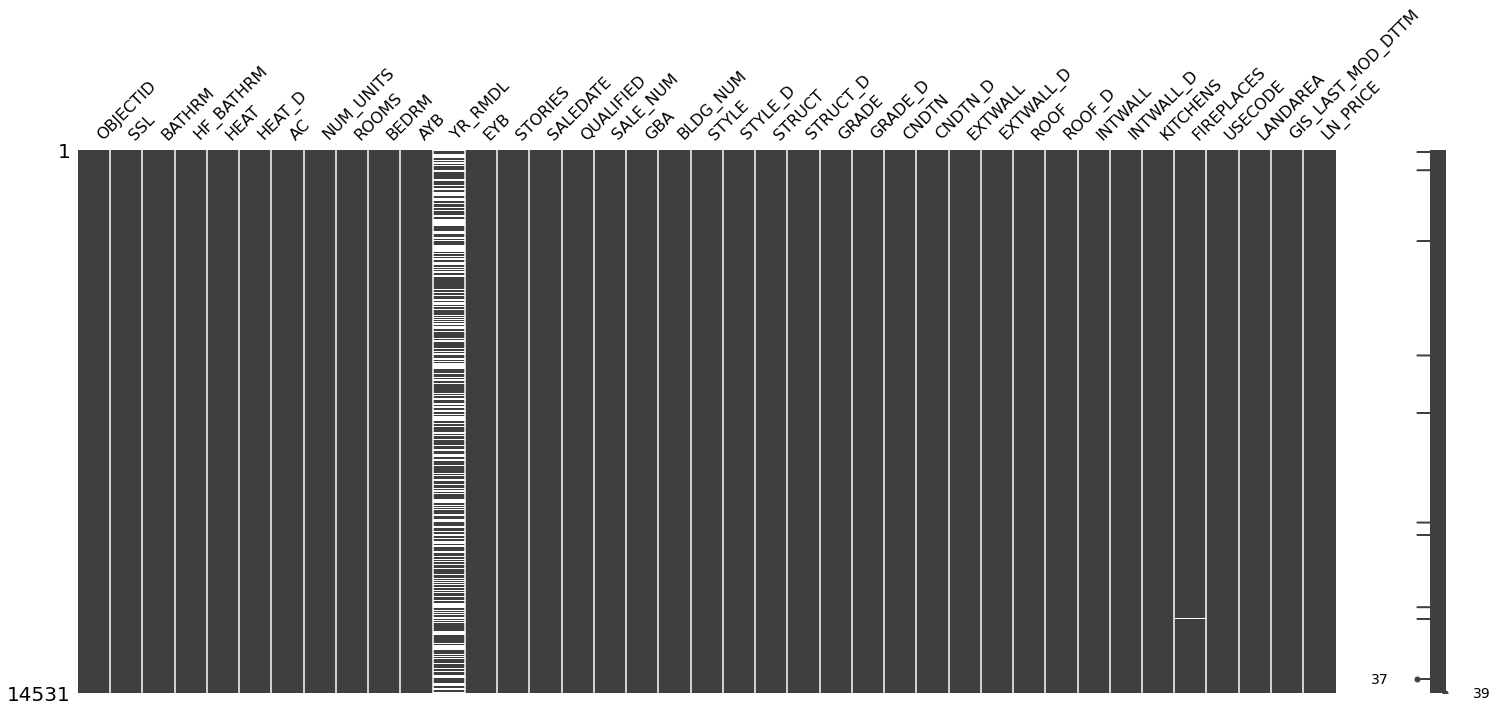

In [5]:
#Look at the missing data
miss.matrix(dat_test)

In [6]:
#Drop all the NA
dat_test = dat_test.dropna()
dat_train = dat_train.dropna()

In [7]:
#Variable choice:
#CNDTN:condition code
#ROOMS:number of rooms
#STORIES: number of stories in primary dwelling
#GBA: gross building area in square feet
train_y = dat_train['LN_PRICE'] 
test_y = dat_test['LN_PRICE'] 
train_X = dat_train[['CNDTN','ROOMS','STORIES','GBA']] 
test_X = dat_test[['CNDTN','ROOMS','STORIES','GBA']]

In [8]:
#Log gross building area
train_X['GBA'] = np.log(train_X['GBA'])
test_X['GBA'] = np.log(test_X['GBA'])

# Explore the training data 

In [9]:
#Look at the train data
train_X

,CNDTN,ROOMS,STORIES,GBA
0,5.0,9.0,2.00,7.138867
2,3.0,9.0,2.50,7.727535
4,3.0,11.0,2.00,7.984803
6,4.0,7.0,1.75,7.228388
7,4.0,7.0,2.00,7.445418
...,...,...,...,...
43585,3.0,5.0,2.00,6.881411
43586,4.0,7.0,2.00,7.379632
43587,4.0,9.0,3.00,7.790696
43588,4.0,6.0,2.00,7.273786


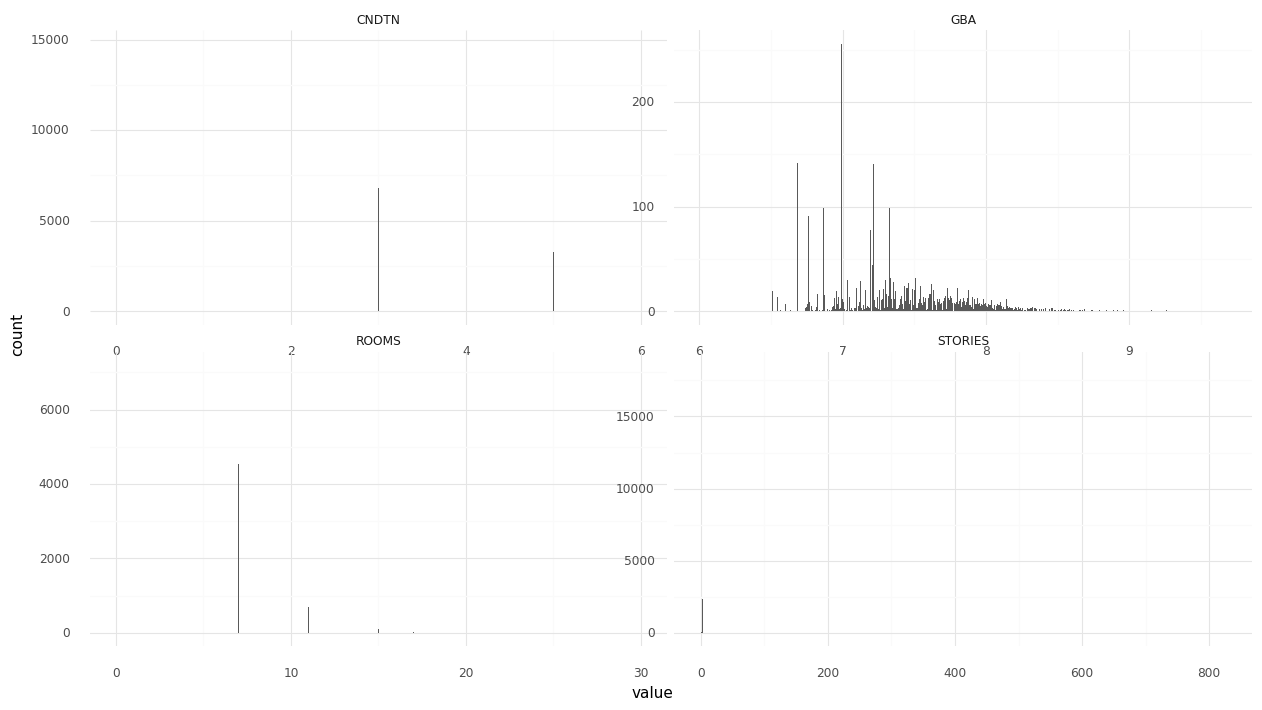

<ggplot: (8766397819588)>

In [10]:
 #Plot the train data to see the predictors' distribution
(
    ggplot(train_X.melt(),aes(x="value")) +
    geom_histogram() +
    facet_wrap("variable",scales="free") +
    theme_minimal() +
    theme(figure_size = (15,8)) 
)


We need to pre-process to address scale issue.

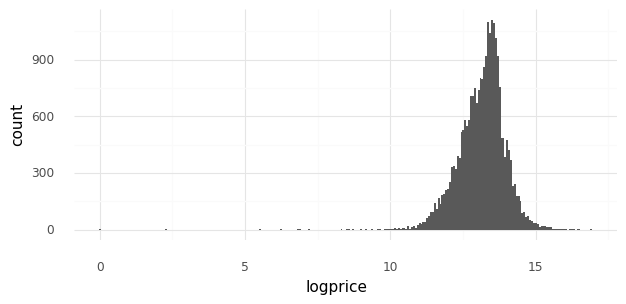

<ggplot: (8766432204189)>

In [11]:
#Look at the outcome price(log format)
(
    ggplot(pd.DataFrame(dict(logprice=train_y)),
           aes(x="logprice")) +
    geom_histogram() +
    theme_minimal() +
    theme(figure_size = (7,3)) 
)

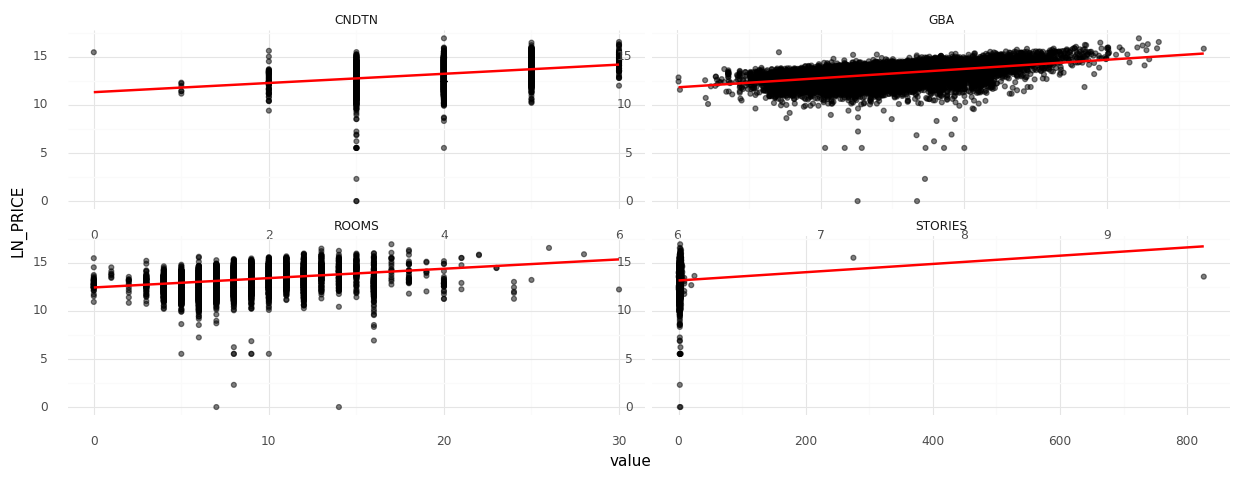

<ggplot: (8766431951866)>

In [12]:
#Look at how the predictors relate to the outcome
D = train_X.copy()
D['LN_PRICE'] = train_y

(
    ggplot(D.melt(id_vars=["LN_PRICE"]),
           aes(x="value",y="LN_PRICE"))+
    geom_point(alpha=.5) +
    facet_wrap("variable",scales="free") +
    geom_smooth(method="lm",se=False,color="red") +
    theme_minimal() +
    theme(figure_size = (15,5)) 
)

# Modeling Pipeline

In [13]:
# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['CNDTN','ROOMS','STORIES','GBA'])])


# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]


# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['CNDTN',
                                                                          'ROOMS',
                                                                          'STORIES',
                                                                          'GBA'])])),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsRegressor(n_neighbors=30)],
                          'model__n_neighbors': [10, 15, 20, 25, 30]},
                         {'model': [DecisionTreeRegressor()],
                          

In [14]:
search.best_score_ # Mean out-of-sample (CV) error

-0.40306618043588294

In [15]:
search.best_params_

{'model': KNeighborsRegressor(n_neighbors=30), 'model__n_neighbors': 30}

# Test performance

In [16]:
# Predict() method will use the best model out of the scan
pred_y = search.predict(test_X)

In [17]:
m.mean_squared_error(test_y,pred_y)

0.3753283349474304

In [18]:
m.r2_score(test_y,pred_y)

0.3806514829715846

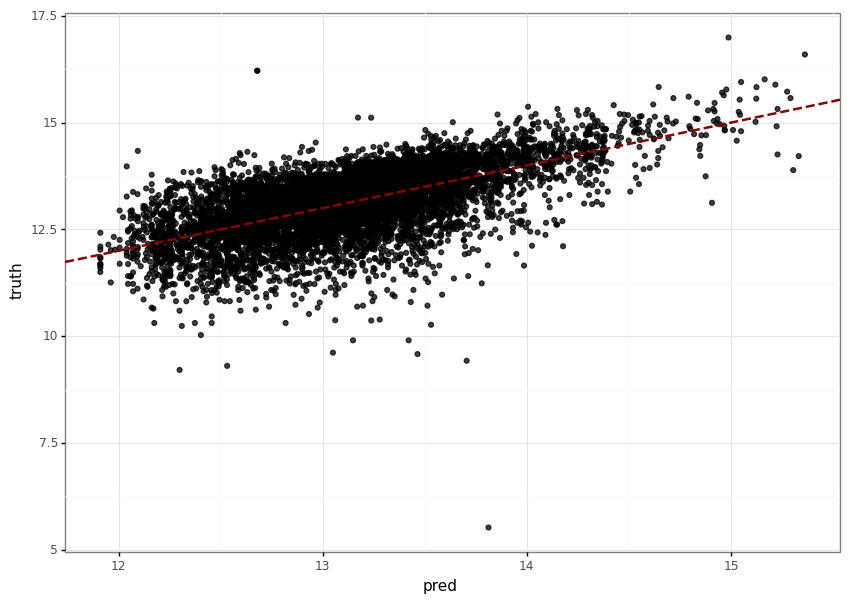

<ggplot: (8766418228649)>

In [19]:
#Plot the relationship between the true values and the prediction
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)

From the result above, the best fit model is KNN with 30 neighbors. The MSE and R-squared values for the model are both 0.38. Including more important variables may increase the accuracy of the model.